# Sequential CRM Experiments

- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/


In [1]:
import sys
import time

In [2]:
import numpy as np

In [77]:
import jax
import jax.numpy as jnp
import jaxopt
from jax.scipy.special import expit as jexpit
from jax.scipy.optimize import minimize as jminimize

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier

from sklearn.multioutput import MultiOutputClassifier, ClassifierChain

from sklearn.model_selection import train_test_split

from sklearn.random_projection import GaussianRandomProjection

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import MultiLabelBinarizer

from sklearn.metrics import hamming_loss

In [5]:
import matplotlib.pyplot as plt

TODO:
- //(softmax temperature ?)
- make sure loss is good
- fix pi0 to be bad

---
## Loading dataset

In [6]:
dataset_name='scene'
# dataset_name='yeast'
#dataset_name='tmc2007'

In [7]:
X_train, y_train_ = load_svmlight_file(dataset_name+'_train.svm', multilabel=True)
X_train = np.array(X_train.todense())
X_train.shape

(1211, 294)

In [8]:
X_test, y_test_ = load_svmlight_file(dataset_name+'_test.svm', multilabel=True)
X_test = np.array(X_test.todense())
X_test.shape

(1196, 294)

In [9]:
onehot_labeller = MultiLabelBinarizer()
y_train = onehot_labeller.fit_transform(y_train_).astype(int)
y_test = onehot_labeller.transform(y_test_).astype(int)

In [10]:
X_all = np.vstack([X_train, X_test])
y_all = np.vstack([y_train, y_test])
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=.25, random_state=0
)
X_train.shape, X_test.shape

((1805, 294), (602, 294))

In [11]:
if dataset_name == 'tmc_2007':
    print("reducing dimension for TMC dataset")
    fh = GaussianRandomProjection(n_components=1000)
    X_train = fh.fit_transform(X_train)
    X_test = fh.transform(X_test)
    print(X_train.shape)

In [12]:
labels = onehot_labeller.classes_.astype(int)
labels

array([0, 1, 2, 3, 4, 5])

(array([1685.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         120.]),
 array([1. , 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. ]),
 <BarContainer object of 10 artists>)

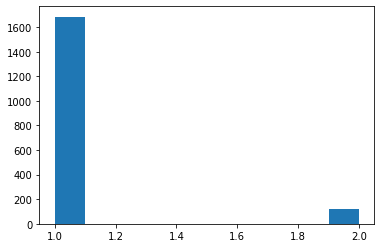

In [13]:
plt.hist(y_train.sum(axis=1))

FYI: Error rate of null policy (always predict 0)

In [14]:
y_test.sum()/(y_test.shape[0])

1.0963455149501662

---
## Our Model

### CRM routines

In [15]:
class CRMDataset(object):
    
    def __init__(self):

        self.propensities_ = []
        self.actions_ = []
        self.rewards_ = []
        self.features_ = []
        
        self.propensities_np = None
        self.actions_np = None
        self.rewards_np = None
        self.features_np = None

        self.check()
        
    def __str__(self):
        if not self.propensities_np:
            return '<CRMDataset>'
        self._generate_numpys()
        return '<CRMDataset propensities:%s actions:%s rewards:%s features:%s>' % (
            self.propensities_np.shape,
            self.actions_np.shape,
            self.rewards_np.shape,
            self.features_np.shape
        )
    
    __repr__ = __str__
        
    def check(self):
        assert len(self.features_) == len(self.propensities_) == len(self.rewards_) == len(self.actions_)
        assert type(self.propensities_) == type(self.actions_) == type(self.rewards_) == type(self.features_) == list        
        
    def __len__(self):
        return len(self.propensities_)
        
    def _generate_arrays(self):
        if self.propensities_np is not None and len(self.propensities_np) == len(self.propensities_):
            return        
        self.propensities_np = jnp.vstack(self.propensities_)
        self.actions_np = jnp.vstack(self.actions_)
        self.rewards_np = jnp.vstack(self.rewards_)
        self.features_np = jnp.vstack(self.features_)
        
    @property
    def actions(self):
        return self.actions_np

    @property
    def propensities(self):
        return self.propensities_np
    
    @property
    def rewards(self):
        return self.rewards_np
    
    @property
    def features(self):
        return self.features_np
        
    def update_from_supervised_dataset(self, X, y, probas, n_samples=4, labels=labels):
        # X is (n,d)
        # y is (n,k)
        # probas is (n,k)

        assert len(X) == len(y) == len(probas), (len(X) , len(y) , len(probas))

        for i in range(len(X)):

            for k in range(n_samples):

                chosen_actions = np.array([np.random.binomial(1, p=probas[i,j]) for j in labels])
                self.actions_ += [chosen_actions]
                self.propensities_ += [probas[i,:]]
                self.features_ += [X[i,:]]
                self.rewards_ += [sum(int(y[i,j] == chosen_actions[j]) for j in labels)]
                
        self._generate_arrays()
        return self

### Modeling

In [154]:
class Model(object):
    
    def __init__(self, beta):
        self.d = beta.shape[0]
        self.k = beta.shape[1]
        self.beta_ = beta
        
    @property
    def beta(self):
        return self.beta_
    
    @beta.setter
    def beta(self, beta):
        # beta is (d, k)
        self.beta_ = beta.reshape(self.d, self.k)
        
    @staticmethod
    def random_model(d, k, seed=None):
        np.random.seed(seed)
        beta = jnp.array(np.random.normal(size=(d, k)))
        return Model(beta)
    
    @staticmethod
    def null_model(d, k):
        beta = jnp.array(np.zeros((d, k)))
        return Model(beta)

    def predict(self, features):
        wx = jnp.dot(features, self.beta_)
        return (wx > 0).astype(int)
    
    def predict_proba(self, features, actions):
        wx = jnp.dot(features, self.beta_)
        actions_sign = 2 * actions - 1
        return jexpit(actions_sign * wx)
    
    def expected_hamming_loss(self, X, y):
        y_invert = 1 - y
        invert_probas = self.predict_proba(X, y_invert)
        return invert_probas.sum() / (self.k * y.shape[0])    
        
    def crm_loss(self, crm_dataset: CRMDataset, 
                 up_clip: float = 1000, 
                 low_clip: float = 1e-9,
                 lambda_: float = 0,
                 verbose: bool = True):

        n = crm_dataset.features.shape[0]

        predictions = self.predict_proba(crm_dataset.features, crm_dataset.actions)       
        predictions = jnp.clip(predictions, low_clip, None)        
        if verbose: jax.debug.print('preds: {} - {}', predictions.min(), predictions.max())
        per_instance_log_predictions = jnp.log(predictions).sum(axis=1)
        
        per_instance_propensities = jnp.clip(crm_dataset.propensities, low_clip, None)
        if verbose: jax.debug.print('props: {} - {}', per_instance_propensities.min(), per_instance_propensities.max())
        per_instance_log_propensities = jnp.log(per_instance_propensities).sum(axis=1)
        
        per_instance_log_importance_weights = per_instance_log_predictions - per_instance_log_propensities
        per_instance_importance_weights = jnp.exp(per_instance_log_importance_weights)                
    
        ips_q10, ips_q90 = jnp.quantile(per_instance_importance_weights, jnp.array([.01,.99]))
        weights_low_clip = jnp.max(jnp.array([ips_q10, low_clip]))
        weights_up_clip = jnp.min(jnp.array([ips_q90, up_clip]))
        if verbose: 
            jax.debug.print("clip:  {} - {}", weights_low_clip, weights_up_clip)
            jax.debug.print("min/max: {} - {}", 
                            per_instance_importance_weights.min(), per_instance_importance_weights.max())
        per_instance_importance_weights = jnp.clip(per_instance_importance_weights, 
                                                   weights_low_clip, weights_up_clip)    
        if verbose: jax.debug.print('ips: {} - {}', per_instance_importance_weights.min(), per_instance_importance_weights.max())
        per_instance_importance_weights = per_instance_importance_weights.reshape(
            (per_instance_importance_weights.shape[0], 1)
        )
        
        per_instance_importance_weighted_rewards = jnp.multiply(
            self.k - crm_dataset.rewards, # to make a loss
            per_instance_importance_weights
        )
        if verbose: jax.debug.print('ipR: {} - {}', per_instance_importance_weighted_rewards.min(), per_instance_importance_weighted_rewards.max())
        
        total_loss = per_instance_importance_weighted_rewards.sum() / per_instance_importance_weights.sum()
        
        if lambda_ > 0:
            total_loss += lambda_ * jnp.sqrt(jnp.var(per_instance_importance_weights) / n)
        
        return total_loss / self.k

### CF Optimization

In [108]:
def iterate_model(model, X, y, sampling_probas, crm_dataset: CRMDataset, 
                  samples_per_instance:int = 4, verbose=False, **loss_args):
    
    loss_args['verbose'] = verbose
        
    # prior_crm_dataset will get extended
    crm_dataset.update_from_supervised_dataset(
        X, y, sampling_probas, 
        n_samples=samples_per_instance
    )
    if verbose: print("Dataset ready:", len(crm_dataset), file=sys.stderr)
    def _loss(beta):
        model.beta = beta
        return model.crm_loss(crm_dataset, **loss_args)
        
    optimizer = jaxopt.ScipyMinimize(method='L-BFGS-B', fun=_loss, maxiter=1000, tol=1e-9)
    solution = optimizer.run(model.beta)
    if verbose: print("Optimi finished:", solution.state, file=sys.stderr)
    model.beta = solution.params
    
    return model

----
## Baselines & Skylines

 ![Perf from CRM article](./basesky.png)

In [18]:
paper_results = {
    'scene': {
        'pi0': 1.543, 'ips': 1.193, 'poem': 1.168, 'pi*':.659
    },
    'yeast': {
        'pi0': 5.547, 'ips': 4.635, 'poem': 4.480, 'pi*':2.282

    }
}

def stoch_hloss(pi, X_test, y_test):
    predictions = pi.predict_proba(X_test)
    predictions = np.array([_[:,1] for _ in predictions]).T
    idx = np.where(y_test == 0)
    fp = predictions[idx].sum()
    idx = np.where(y_test == 1)
    fn = (1-predictions[idx]).sum()
    return (fn+fp)/(y_test.shape[0]*y_test.shape[1])


def result_table(pi0, pistar, X_test, y_test, ips_loss=None, poem_loss=None):
    
    stats = paper_results[dataset_name]
    
    print('Baseline -- paper: %.3f -- ours: %.3f' % (stats["pi0"]/y_test.shape[1], 
                                                     stoch_hloss(pi0, X_test, y_test)))
    print('IPS      -- paper: %.3f' % (stats["ips"]/y_test.shape[1]), end='')
    if ips_loss is not None:
        print(' -- ours: %.3f' % ips_loss)
    else:
        print()
    print('POEM     -- paper: %.3f' % (stats["poem"]/y_test.shape[1]), end='')
    if poem_loss is not None:
        print(' -- ours: %.3f' % poem_loss)
    else:
        print()
    print('Skyline  -- paper: %.3f -- ours: %.3f' % (stats["pi*"]/y_test.shape[1], 
                                                     stoch_hloss(pistar, X_test, y_test)))    

In [39]:
pistar = MultiOutputClassifier(LogisticRegressionCV(max_iter=10000, n_jobs=6, solver='lbfgs', tol=1e-6, cv=5))
pistar.fit(X_train, y_train)

MultiOutputClassifier(estimator=LogisticRegressionCV(cv=5, max_iter=10000,
                                                     n_jobs=6, tol=1e-06))

In [21]:
pi0 = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=30),#penalty='l2', C=1e-9, fit_intercept=0, intercept_scaling=0), 
                            n_jobs=6)

X_0, _, y_0, _ = train_test_split(X_train, y_train, test_size=.95, random_state=0)
print('learning pi0 on', len(X_0), 'data points')

pi0.fit(X_0, y_0)

learning pi0 on 90 data points


MultiOutputClassifier(estimator=KNeighborsClassifier(n_neighbors=30), n_jobs=6)

In [22]:
# pi0 = MultiOutputClassifier(LogisticRegression(dual=True, solver='liblinear', max_iter=1000), n_jobs=6)
# X_0, _, y_0, _ = train_test_split(X_train, y_train, test_size=.95, random_state=42)
# pi0.fit(X_0, y_0)

In [44]:
result_table(pi0, pistar, X_test, y_test)

Baseline -- paper: 0.257 -- ours: 0.251
IPS      -- paper: 0.199
POEM     -- paper: 0.195
Skyline  -- paper: 0.110 -- ours: 0.144


---
## Classical CRM

In [23]:
# useful to check the online CRM optimization
# (this CRM dataset is supposedly less biased than the online one the optim observes)
ref_crm_dataset = CRMDataset().update_from_supervised_dataset(
    X_train, y_train, 
    np.ones((X_train.shape[0], y_train.shape[1]))*.5,
    n_samples=10
)

In [160]:
random_model = Model.random_model(X_test.shape[1], y_test.shape[1])
print('beta0 Exp. H. loss: %.3f' % random_model.expected_hamming_loss(X_test, y_test))
print('beta0 CRM Loss (unif): %.3f' % random_model.crm_loss(ref_crm_dataset, up_clip=50000))

beta0 Exp. H. loss: 0.407
preds: 9.999999717180685e-10 - 1.0
props: 0.5 - 0.5
clip:  9.999999717180685e-10 - 44.91791534423828
min/max: 4.3179586803020694e-32 - 63.96323776245117
ips: 9.999999717180685e-10 - 44.91791534423828
ipR: 0.0 - 179.67166137695312
beta0 CRM Loss (unif): 0.409


In [161]:
ips_losses = []
poem_losses = []
for i in range(10):
    ips_model = Model.null_model(X_test.shape[1], y_test.shape[1])
#     ips_model = Model.random_model(X_test.shape[1], y_test.shape[1], seed=i*42)
    poem_model = Model(ips_model.beta)
    
    ips_crm_dataset = CRMDataset()
    poem_crm_dataset = CRMDataset()
    sampling_probas = pi0.predict_proba(X_train)
    sampling_probas = np.array([_[:,1] for _ in sampling_probas]).T
    
    np.random.seed(i*42)
    iterate_model(
        ips_model, X_train, y_train, sampling_probas, ips_crm_dataset, 
        samples_per_instance=4,
        verbose=0, 
        lambda_ = 0,
        up_clip = 5e4,
        low_clip = 1e-9
    )
    print("IPS     E[HL]: %.3f | CRM Loss (++data): %.3f | CRM Loss: %.3f" % (
        ips_model.expected_hamming_loss(X_test, y_test), 
        ips_model.crm_loss(ref_crm_dataset, verbose=0), 
        ips_model.crm_loss(ips_crm_dataset, verbose=0)
    ))
    ips_losses += [ips_model.expected_hamming_loss(X_test, y_test)]    

    np.random.seed(i*42)
    iterate_model(
        poem_model, X_train, y_train, sampling_probas, poem_crm_dataset, 
        samples_per_instance=4,
        verbose=0, 
        lambda_ = .001, 
        up_clip = 5e4,
        low_clip = 1e-9
    )
    print("POEM    E[HL]: %.3f | CRM Loss (++data): %.3f | CRM Loss: %.3f" % (
        poem_model.expected_hamming_loss(X_test, y_test), 
        poem_model.crm_loss(ref_crm_dataset, verbose=0), 
        poem_model.crm_loss(poem_crm_dataset, verbose=0)
    ))
    poem_losses += [poem_model.expected_hamming_loss(X_test, y_test)]    
print()

ips_losses = np.array(ips_losses)
poem_losses = np.array(poem_losses)

diff = ips_losses - poem_losses

print('CI(L(IPS) - L(POEM)) @ alpha=5%%: [%.4f ; %.4f]' % (
    diff.mean() - 1.64*np.std(diff)/np.sqrt(10), diff.mean() + 1.64*np.std(diff)/np.sqrt(10)
), '\n')

result_table(pi0, pistar, X_test, y_test, ips_loss=np.mean(ips_losses), poem_loss=np.mean(poem_losses))

IPS     E[HL]: 0.172 | CRM Loss (++data): 0.164 | CRM Loss: 0.192
POEM    E[HL]: 0.153 | CRM Loss (++data): 0.148 | CRM Loss: 0.178
IPS     E[HL]: 0.172 | CRM Loss (++data): 0.163 | CRM Loss: 0.195
POEM    E[HL]: 0.162 | CRM Loss (++data): 0.147 | CRM Loss: 0.185
IPS     E[HL]: 0.161 | CRM Loss (++data): 0.159 | CRM Loss: 0.183
POEM    E[HL]: 0.165 | CRM Loss (++data): 0.155 | CRM Loss: 0.186
IPS     E[HL]: 0.171 | CRM Loss (++data): 0.162 | CRM Loss: 0.193
POEM    E[HL]: 0.177 | CRM Loss (++data): 0.175 | CRM Loss: 0.173
IPS     E[HL]: 0.172 | CRM Loss (++data): 0.164 | CRM Loss: 0.193
POEM    E[HL]: 0.155 | CRM Loss (++data): 0.151 | CRM Loss: 0.178
IPS     E[HL]: 0.173 | CRM Loss (++data): 0.166 | CRM Loss: 0.195
POEM    E[HL]: 0.166 | CRM Loss (++data): 0.161 | CRM Loss: 0.182
IPS     E[HL]: 0.174 | CRM Loss (++data): 0.165 | CRM Loss: 0.193
POEM    E[HL]: 0.150 | CRM Loss (++data): 0.139 | CRM Loss: 0.180
IPS     E[HL]: 0.183 | CRM Loss (++data): 0.175 | CRM Loss: 0.201
POEM    E[

---
## Sequential CRM

### Tracing

In [26]:
class LossHistory(object):
    
    def __init__(self, name, ref_crm_dataset, X_test, y_test):
        self.name = name
        self.ref_crm_dataset = ref_crm_dataset
        self.X_test = X_test
        self.y_test = y_test
        self.hamming_loss = []
        self.crm_loss = []
        self.unif_crm_loss = []
        self.betas = []
        self.n_samples = []
        self.n_actions = []
        self.rewards = []
        
    def update(self, model: Model, crm_dataset: CRMDataset):
        self.betas += [model.beta]
        self.hamming_loss += [model.expected_hamming_loss(self.X_test, self.y_test)]
        self.crm_loss += [model.crm_loss(crm_dataset)]
        self.unif_crm_loss += [model.crm_loss(self.ref_crm_dataset)]
        self.n_samples += [len(crm_dataset)]
        self.n_actions += [np.sum(crm_dataset.actions_)]
        self.rewards += [np.sum(crm_dataset.rewards_)]
        
    def show_last(self):
        print(
            '<', self.name,
            'Ham. loss: %.5f' % self.hamming_loss[-1], 
            'CRM loss: %.5f' % self.crm_loss[-1],
            'CRM loss (U): %.5f' % self.unif_crm_loss[-1],
            '|beta|=%.2f' % np.sqrt((self.betas[-1]**2).sum()), 
            'n=%d' % self.n_samples[-1],
            '|A|=%d' % self.n_actions[-1],
            '|R|=%d' % self.rewards[-1],
            '>',
            file=sys.stderr
        )

### The Experiment

In [ ]:
rollouts = 

In [27]:
static_model = Model.random_model(X_test.shape[1], y_test.shape[1])
dynamic_model = Model.random_model(X_test.shape[1], y_test.shape[1])

static_crm_dataset = CRMDataset()
dynamic_crm_dataset = CRMDataset()

static_loss_history = LossHistory("Static", ref_crm_dataset, X_test, y_test)
dynamic_loss_history = LossHistory("Dynamic", ref_crm_dataset, X_test, y_test)

epochs = 1
n_episods = 1
batch = int(len(X_train) / n_episods)
replays = 4

for _ in range(epochs):
    
    print('*'*30, 'PASS %d/%d'% (_+1, epochs), '*'*30, file=sys.stderr)
    for episod in range(n_episods):
        start = episod*batch
        end = (episod+1)*batch
        t_start = time.time()

        # current slice of dataset
        X = X_train[start:end,:]
        y = y_train[start:end,:]
       
        #### static CRM 
        ## action probas
        sampling_probas_static = pi0.predict_proba(X)
        sampling_probas_static = np.array([_[:,1] for _ in sampling_probas_static]).T
        ## optimize
        iterate_model(
            static_model, X, y, sampling_probas_static, static_crm_dataset, 
            samples_per_instance=replays,
        )
        ## record
        static_loss_history.update(static_model, static_crm_dataset)
        static_loss_history.show_last()
        
        #### sequential CRM 
        ## action probas
#         if episod == 0:
#             sampling_probas_dynamic = sampling_probas_static
#         else:
#             sampling_probas_dynamic = dynamic_model.predict_proba(X, y)        
#         ## optimize
#         iterate_model(
#             dynamic_model, X, y, sampling_probas_dynamic, dynamic_crm_dataset,
#             samples_per_instance=replays,
#         )
#         ## record
#         dynamic_loss_history.update(dynamic_model, dynamic_crm_dataset)
#         dynamic_loss_history.show_last()
        t_end = time.time()
    
        print('*'*20, 'episod: %d/%d' % (episod+1, n_episods), 
              'time: %ds' % (t_end - t_start), '*'*20, file=sys.stderr)


****************************** PASS 1/1 ******************************
< Static Ham. loss: 0.38799 CRM loss: 0.06036 CRM loss (U): 0.39909 |beta|=144.70 n=7220 |A|=7831 |R|=32583 >
******************** episod: 1/1 time: 1s ********************


### Insights

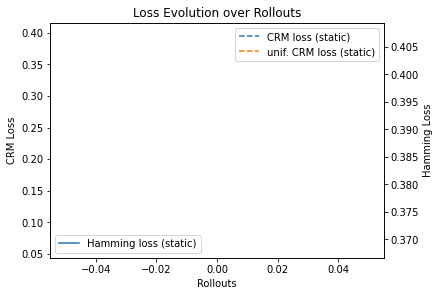

In [28]:
fig, ax = plt.subplots(constrained_layout=True)
plt.title('Loss Evolution over Rollouts')
ax.set_xlabel('Rollouts')
ax.set_ylabel('CRM Loss')
ax.plot(static_loss_history.crm_loss, '--', label='CRM loss (static)')
# ax.plot(dynamic_loss_history.crm_loss, '--', label='CRM loss (dynamic)')
ax.plot(static_loss_history.unif_crm_loss, '--', label='unif. CRM loss (static)')
# ax.plot(dynamic_loss_history.unif_crm_loss, '--', label='unif. CRM loss (dynamic)')
ax.legend(loc='upper right')
ax2 = ax.twinx()
ax2.plot(static_loss_history.hamming_loss, label='Hamming loss (static)')
# ax2.plot(dynamic_loss_history.hamming_loss, label='Hamming loss (dynamic)')
ax2.set_ylabel('Hamming Loss')
ax2.legend(loc='lower left')

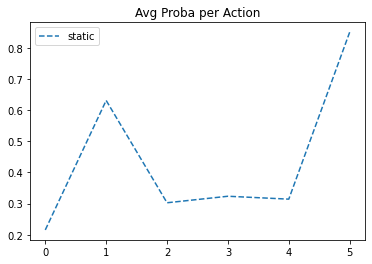

In [29]:
plt.title('Avg Proba per Action')
plt.plot(jexpit(static_model.beta.mean(axis=0)),'--', label='static')
# plt.plot(jexpit(beta_dynamic.mean(axis=0)),'--', label='dynamic')
plt.legend()

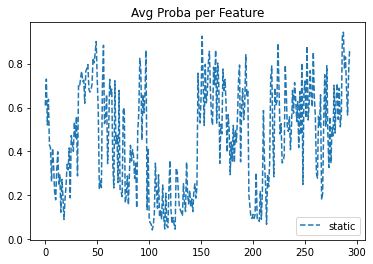

In [30]:
plt.title('Avg Proba per Feature')
plt.plot(jexpit(static_model.beta.mean(axis=1)),'--', label='static')
plt.legend()

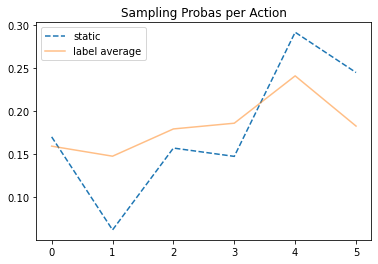

In [31]:
plt.title('Sampling Probas per Action')
plt.plot(sampling_probas_static.mean(axis=0),'--', label='static')
# plt.plot(sampling_probas_dynamic.mean(axis=0),'--', label='dynamic')
plt.plot(y_test.mean(axis=0), label='label average', alpha=.5)
plt.legend()